<a href="https://colab.research.google.com/github/dimazjogja/electronic-failure/blob/main/VendorRecommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
!pip install geopandas
!pip install haversine
!pip install imbalanced-learn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 13.0 MB/s 
     |████████████████████████████████| 16.7 MB 207 kB/s 
     |████████████████████████████████| 6.3 MB 34.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import plotly

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, Polygon
import re
import string
import pickle
import os, sys

import warnings
warnings.filterwarnings("ignore")

from collections import Counter

#*Import Data*

In [3]:
orders = pd.read_csv("/content/drive/MyDrive/Traveloka/orders.csv")
vendors = pd.read_csv("/content/drive/MyDrive/Traveloka/vendors.csv")
ts_customers = pd.read_csv("/content/drive/MyDrive/Traveloka/test_customers.csv")
ts_locations = pd.read_csv("/content/drive/MyDrive/Traveloka/test_locations.csv")
tr_customers = pd.read_csv("/content/drive/MyDrive/Traveloka/train_customers.csv")
tr_locations = pd.read_csv("/content/drive/MyDrive/Traveloka/train_locations.csv")
print(orders.columns)
print(vendors.columns)
print(tr_customers.columns)
print(tr_locations.columns)

Index(['akeed_order_id', 'customer_id', 'item_count', 'grand_total',
       'payment_mode', 'promo_code', 'vendor_discount_amount',
       'promo_code_discount_percentage', 'is_favorite', 'is_rated',
       'vendor_rating', 'driver_rating', 'deliverydistance', 'preparationtime',
       'delivery_time', 'order_accepted_time', 'driver_accepted_time',
       'ready_for_pickup_time', 'picked_up_time', 'delivered_time',
       'delivery_date', 'vendor_id', 'created_at', 'LOCATION_NUMBER',
       'LOCATION_TYPE', 'CID X LOC_NUM X VENDOR'],
      dtype='object')
Index(['id', 'authentication_id', 'latitude', 'longitude',
       'vendor_category_en', 'vendor_category_id', 'delivery_charge',
       'serving_distance', 'is_open', 'OpeningTime', 'OpeningTime2',
       'prepration_time', 'commission', 'is_akeed_delivering',
       'discount_percentage', 'status', 'verified', 'rank', 'language',
       'vendor_rating', 'sunday_from_time1', 'sunday_to_time1',
       'sunday_from_time2', 'sunday_to_ti

In [4]:
print('A. The customers data, Top 5 Rows: ', 'Shape:', tr_customers.shape)
tr_customers = tr_customers[['akeed_customer_id', 'gender', 'status', 'verified', 'language']]
tr_customers.head(2)

A. The customers data, Top 5 Rows:  Shape: (34674, 8)


,akeed_customer_id,gender,status,verified,language
0,TCHWPBT,Male,1,1,EN
1,ZGFSYCZ,Male,1,1,EN


In [5]:
gender = pd.DataFrame()
gender['customer_id'] = tr_customers['akeed_customer_id']
gender['gender'] = tr_customers['gender']

In [6]:
print('B. The location data, Top 5 Rows: ')
print('Shape:', tr_locations.shape)
tr_locations = tr_locations[['customer_id', 'location_number', 'location_type', 'latitude', 'longitude']]
tr_locations.head(2)

B. The location data, Top 5 Rows: 
Shape: (59503, 5)


,customer_id,location_number,location_type,latitude,longitude
0,02SFNJH,0,NaN,1.682392,-78.789737
1,02SFNJH,1,NaN,1.679137,0.766823


In [7]:
print('C. The orders data, Top 5 Rows: ')
print('Shape:', orders.shape)
orders.drop(['akeed_order_id','promo_code','promo_code_discount_percentage','delivery_date','created_at'], axis=1, errors='ignore', inplace=True)
orders.head(2)

C. The orders data, Top 5 Rows: 
Shape: (135303, 26)


,customer_id,item_count,grand_total,payment_mode,vendor_discount_amount,is_favorite,is_rated,vendor_rating,driver_rating,deliverydistance,...,delivery_time,order_accepted_time,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,vendor_id,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
0,92PEE24,1.0,7.6,2,0.0,NaN,No,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,105,0,NaN,92PEE24 X 0 X 105
1,QS68UD8,1.0,8.7,1,0.0,NaN,No,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,294,0,Work,QS68UD8 X 0 X 294


In [8]:
print('D. Total Vendors ,Top 5 Rows: ')
vendors['vendor_id']=vendors['id']
vendors.head(2)

D. Total Vendors ,Top 5 Rows: 


,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,...,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders,vendor_id
0,4,118597.0,-0.588596,0.754434,Restaurants,2.0,0.0,6.0,1.0,11:00AM-11:30PM,...,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1,4
1,13,118608.0,-0.471654,0.744470,Restaurants,2.0,0.7,5.0,1.0,08:30AM-10:30PM,...,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1,13


In [9]:
# creating the final table after
final_df = pd.DataFrame()
final_df['customer_id'] = orders['customer_id']
final_df['location_number'] = orders['LOCATION_NUMBER']
final_df['vendor_id'] = orders['vendor_id']
final_df = pd.merge(final_df, tr_locations, how="outer", on=['customer_id', 'location_number'])
final_df = pd.merge(final_df, gender, how='outer', on=['customer_id'])

In [10]:
# dropping unnecessary columns
final_df.drop_duplicates(inplace=True)
final_df['cus_lat'] = final_df['latitude']
final_df['cus_long'] = final_df['longitude']
final_df.drop(['latitude', 'longitude'], axis=1, inplace=True)

In [11]:
final = pd.merge(final_df, vendors, how="outer", on=['vendor_id'])
final.drop_duplicates(inplace=True)
final = final[['customer_id', 'location_number', 'gender', 'vendor_id', 'cus_lat', 'cus_long',\
             'latitude', 'longitude', 'vendor_category_en', 'delivery_charge', 'serving_distance', 'is_open',\
             'prepration_time', 'is_akeed_delivering', 'vendor_rating', 'one_click_vendor']]
final.head(2)

,customer_id,location_number,gender,vendor_id,cus_lat,cus_long,latitude,longitude,vendor_category_en,delivery_charge,serving_distance,is_open,prepration_time,is_akeed_delivering,vendor_rating,one_click_vendor
0,92PEE24,0,Male,105.0,-0.132100,-78.575297,-0.967769,0.080839,Restaurants,0.0,15.0,1.0,12.0,Yes,4.5,Y
1,92PEE24,1,Male,105.0,-0.760509,-78.501031,-0.967769,0.080839,Restaurants,0.0,15.0,1.0,12.0,Yes,4.5,Y


In [12]:
print('Shape of data:', final.shape)
print('Columns in data:', final.columns)

Shape of data: (96020, 16)
Columns in data: Index(['customer_id', 'location_number', 'gender', 'vendor_id', 'cus_lat',
       'cus_long', 'latitude', 'longitude', 'vendor_category_en',
       'delivery_charge', 'serving_distance', 'is_open', 'prepration_time',
       'is_akeed_delivering', 'vendor_rating', 'one_click_vendor'],
      dtype='object')


## *Vendor Top 25*

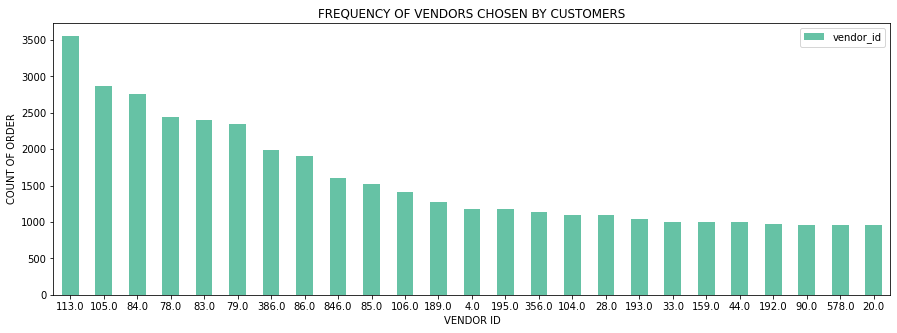

In [13]:
fig, ax = plt.subplots()
final['vendor_id'].value_counts().head(25).plot(ax=ax, kind='bar', figsize=(15, 5), cmap='Set2')
plt.xlabel('VENDOR ID'); plt.ylabel('COUNT OF ORDER'); plt.title('FREQUENCY OF VENDORS CHOSEN BY CUSTOMERS')
plt.xticks(rotation=0); ax.legend()

**PLOT DESCRIPTION AND OBSERVATIONS:**

1. We can see vendors such as 113, 105, 84, 79, 368, 86 and 846 contains 25 percentile of total vendors chosen.

2. In recommendation these vendors will have a high chance of being recommended by customers.

# **1. Feature Analysis - Univariate**

##*Locations (Latitude - Longitude)*

In [14]:
# creating a dataframe to analyze customers and vendors locations over map
location_cust = pd.DataFrame()
location_cust['vendor'] = final['vendor_id']
location_cust['latitude'] = final['cus_lat']
location_cust['longitude'] = final['cus_long']
location_cust['ven_lat'] = final['latitude']
location_cust['ven_lon'] = final['longitude']

# dropping locations with anomalies and using coordinated between (-90,90) for latitudes and (-180,180) for longitudes
location_cust.drop(location_cust.loc[(location_cust['latitude']<-90) | (location_cust['latitude']>90)].index, inplace=True)
location_cust.drop(location_cust.loc[(location_cust['longitude']<-180) | (location_cust['longitude']>180)].index, inplace=True)
location_cust.drop(location_cust.loc[(location_cust['ven_lat']<-90) | (location_cust['ven_lat']>90)].index, inplace=True)
location_cust.drop(location_cust.loc[(location_cust['ven_lon']<-180) | (location_cust['ven_lon']>180)].index, inplace=True)

### *a. Location of Customers (IMPORTANT)*

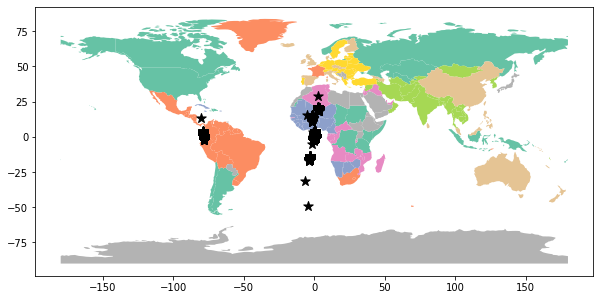

In [15]:
# locations of customers over map who make order
geo = [Point(x) for x in zip(location_cust['longitude'], location_cust['latitude'])]
gdf = gpd.GeoDataFrame(location_cust, geometry=geo)   
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax = world.plot(figsize=(10,10), cmap='Set2'), marker='*', color='black', markersize=100);

**PLOT DESCRIPTION AND OBSERVATIONS:**

1. Here the locations of all customers who ordered something are shown.

2. There were around 5000 wrong coordinates removed to get them plotted into the world map(lat:(-90,90) long:(-180,180)). But still we get some locations are from sea.

3. Most of the customers are from Africa and some are from South America.

4. Using customer only locations will not be a much use in our recommendation process. We have to see the vendors locations as well.

### *b. Location of Vendors (IMPORTANT)*

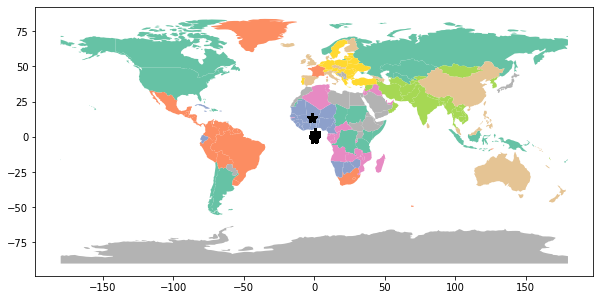

In [16]:
# locations of vendors over map who received orders
geo = [Point(x) for x in zip(location_cust['ven_lon'], location_cust['ven_lat'])]
gdf = gpd.GeoDataFrame(location_cust, geometry=geo)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10,10), cmap='Set2'), marker='*', color='black', markersize=100);

**PLOT SUMMARY:**

1. There were invalid latitudes and longitudes I found and removed them to get shape in the world map(lat:(-90,90) long:(-180,180)). Still some locations are from sea.

2. All the vendors are from Africa, but as we can see using these longitudes and latitudes, finding recommendations are tough. 

3. We have to see distance between customers and vendors locations in next approaches.

### *c. Distance Customers-Vendors (IMPORTANT)*

In [17]:
location_cust.columns

Index(['vendor', 'latitude', 'longitude', 'ven_lat', 'ven_lon', 'geometry'], dtype='object')

In [18]:
import haversine
from haversine import haversine_vector, Unit

dist = []
location_cust.dropna(inplace=True)
for i in location_cust.values:
    a = (i[1], i[2])
    b = (i[3], i[4])
    dist.append(haversine_vector([a], [b], Unit.KILOMETERS)[0])

location_cust['distance'] = dist
location_cust.head(2)

,vendor,latitude,longitude,ven_lat,ven_lon,geometry,distance
0,105.0,-0.132100,-78.575297,-0.967769,0.080839,POINT (0.08084 -0.96777),8746.108027
1,105.0,-0.760509,-78.501031,-0.967769,0.080839,POINT (0.08084 -0.96777),8736.757038


Text(0.5, 1.0, 'DISTANCE OF CUSTOMER-VENDOR')

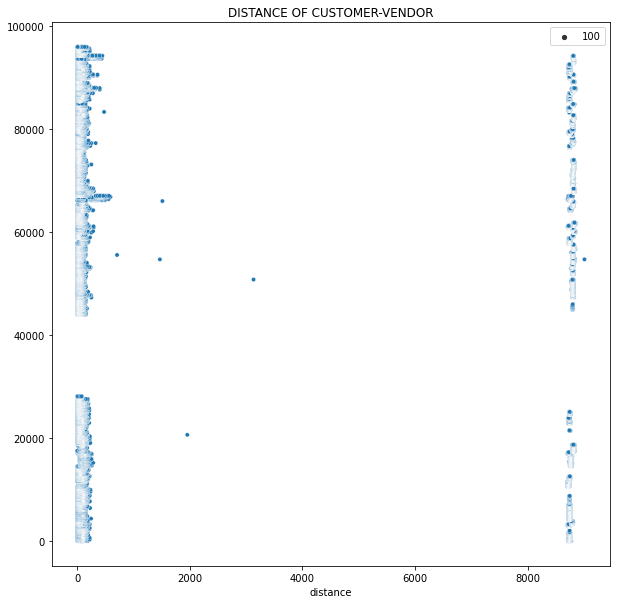

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=location_cust, x="distance", y=location_cust.index, cmap='blue', size=100)
plt.title("DISTANCE OF CUSTOMER-VENDOR")

**PLOT SUMMARY:**

1. There are 2 seperate regions, first those ordered from South America whose distances are around 8000 km and second who ordered from Africa whose distances are under 500 km. Also vendor with id's less than 200 are most favorites.

2. Customers prefer ordering from vendors in 500 km range most in Africa and when you are in South America it is in range 8000km.

3. But why people having distance of more than 8000 are shown, because travelling to a different continent for restaurant is quite different.

## *Vendors Category (LESS IMPORTANT)*

In [20]:
# there are only 2 categories seen and most of them were restaurants
final['vendor_category_en'].value_counts()

Restaurants       70854
Sweets & Bakes     9301
Name: vendor_category_en, dtype: int64

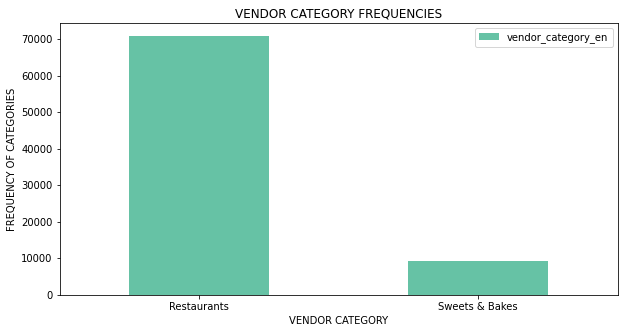

In [21]:
fig, ax = plt.subplots()
final['vendor_category_en'].value_counts().plot(ax=ax, kind='bar', figsize=(10, 5), cmap='Set2')
plt.xlabel('VENDOR CATEGORY'); plt.ylabel('FREQUENCY OF CATEGORIES'); plt.title("VENDOR CATEGORY FREQUENCIES")
plt.xticks(rotation = 0); ax.legend()

**PLOT SUMMARY:**

1. There are only 2 broad categories. restaurants and sweets and bakes.

2. Most vendors are from restaurant category and 20k are from sweets and bakes.category is not a much important feature for recommendation it seems.



##*Delivery Charge Analysis (LESS IMPORTANT)*

In [22]:
final['delivery_charge'].value_counts()

0.0    40369
0.7    39786
Name: delivery_charge, dtype: int64

**PLOT SUMMARY:**

1.In the presense of delivery charge (0.7) and no delivery charge (0.0), there are almost same numbers of orders and it dosen't affect the orders.
2.This feature is not important for us in this recommendation.

##*Frequency*

###*a. Frequency - Vendor Rating (IMPORTANT)*

In [23]:
final['vendor_rating'].value_counts()

4.5    17809
4.3    14867
4.2    11784
4.4    11102
4.7     7471
4.6     7462
4.1     3786
4.0     2854
3.8      959
3.2      880
4.8      750
3.7      431
Name: vendor_rating, dtype: int64

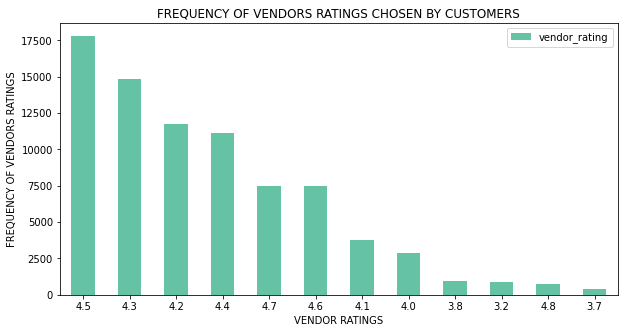

In [24]:
fig, ax = plt.subplots()
final['vendor_rating'].value_counts().plot(ax=ax, kind='bar', figsize=(10, 5), cmap='Set2')
plt.xlabel('VENDOR RATINGS'); plt.ylabel('FREQUENCY OF VENDORS RATINGS'); plt.title("FREQUENCY OF VENDORS RATINGS CHOSEN BY CUSTOMERS")
plt.xticks(rotation = 0); ax.legend()

**PLOT SUMMARY:**

1. Most of the customers have ordered from the vendors with vendor ratings greater than 4.0.

2. If ratings are near to 5, chances of ordering is high and that's why rating is very important tool for use.

###*b. Frequency - Serving Distance (IMPORTANT)*

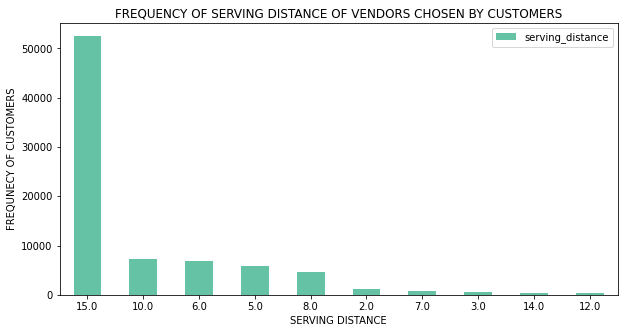

In [25]:
fig, ax = plt.subplots()
final['serving_distance'].value_counts().plot(ax=ax, kind='bar',figsize=(10,5), cmap='Set2')
plt.xlabel('SERVING DISTANCE'); plt.ylabel('FREQUNECY OF CUSTOMERS'); plt.title("FREQUENCY OF SERVING DISTANCE OF VENDORS CHOSEN BY CUSTOMERS")
plt.xticks(rotation=0); ax.legend()

**PLOT SUMMARY:**

1. If the vendor has a serving distance of 15, chances are high that the customer will have an order.

2. This feature is important for making recommendation.

###*c. Frequency - Is Vendor Open (IMPORTANT)*

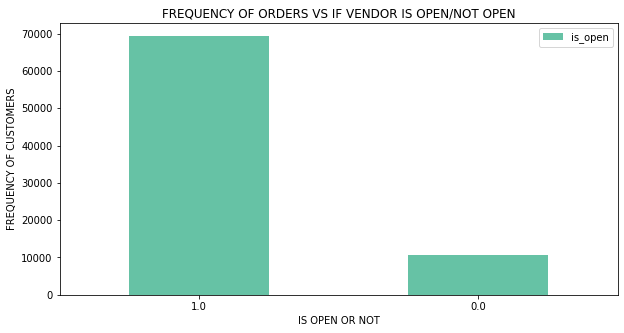

In [26]:
fig, ax = plt.subplots()
final['is_open'].value_counts().plot(ax=ax, kind='bar',figsize=(10,5), cmap='Set2')
plt.xlabel('IS OPEN OR NOT'); plt.ylabel('FREQUENCY OF CUSTOMERS'); plt.title("FREQUENCY OF ORDERS VS IF VENDOR IS OPEN/NOT OPEN")
plt.xticks(rotation=0); ax.legend()

**PLOT SUMMARY:**

1. If it's open then high chance is there but even if it is not open, there are 10000 orders made, that is quite an anomaly.

2. Hence this feature is useful to some extent for our recommendations.

###*d. Frequency - Vendor Prepration Time (IMPORTANT)*

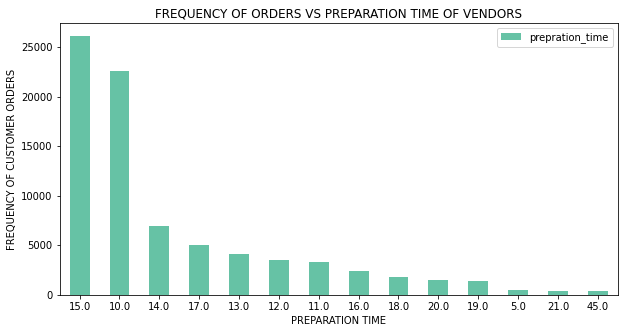

In [27]:
fig, ax = plt.subplots()
final['prepration_time'].value_counts().plot(ax=ax, kind='bar', figsize=(10,5), cmap='Set2')
plt.xlabel('PREPARATION TIME'); plt.ylabel('FREQUENCY OF CUSTOMER ORDERS'); plt.title("FREQUENCY OF ORDERS VS PREPARATION TIME OF VENDORS")
plt.xticks(rotation=0); ax.legend()

**PLOT SUMMARY:**

1. We can see that standard time 10 and 15 mins are highly appreciated but also if the time is under 5, there are less orders. So it can depend on orders and type of orders.

2. So this feature can be useful if and if only type of orders taken into account otherwise confusing.

###*e. Frequency - Vendor with One Click (LESS IMPORTANT)*

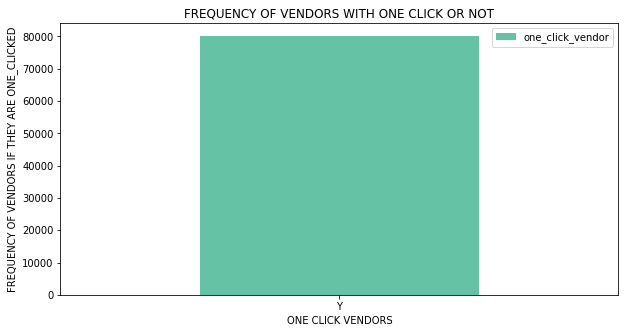

In [28]:
fig, ax = plt.subplots()
final['one_click_vendor'].value_counts().plot(ax=ax, kind='bar', figsize=(10,5), cmap='Set2')
plt.xlabel('ONE CLICK VENDORS'); plt.ylabel('FREQUENCY OF VENDORS IF THEY ARE ONE_CLICKED'); plt.title("FREQUENCY OF VENDORS WITH ONE CLICK OR NOT")
plt.xticks(rotation=0); ax.legend()

**PLOT SUMMARY**
1. All the customers have chosen vendors with one_click service enables, this feature is not useful for our recommendation.

### *f. Frequency - Customer Gender (LESS IMPORTANT)*

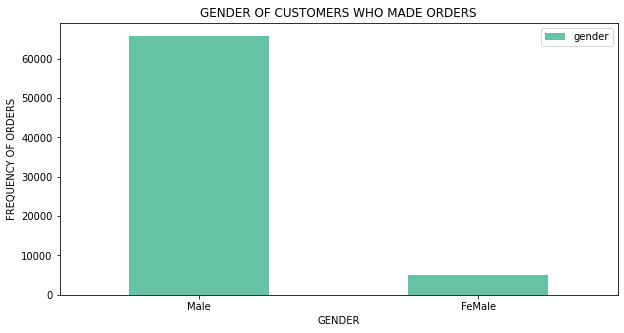

In [29]:
fig, ax = plt.subplots()
final.gender = final.gender.str.replace('male', 'Male')
final.gender = final['gender'].dropna()
final = final[(final.gender == "Male") | (final.gender == "FeMale")]
final['gender'].value_counts().plot(ax=ax, kind='bar', figsize=(10,5), cmap='Set2')
plt.xlabel('GENDER'); plt.ylabel('FREQUENCY OF ORDERS'); plt.title("GENDER OF CUSTOMERS WHO MADE ORDERS")
plt.xticks(rotation=0); ax.legend()

**PLOT SUMMARY**

1. As we can see there are 70k, around 80% of the customers as male and 10k as female. This can be a good feature but not to great extent.

### *g. Frequency - Subscription of Delivery (LESS IMPORTANT)*

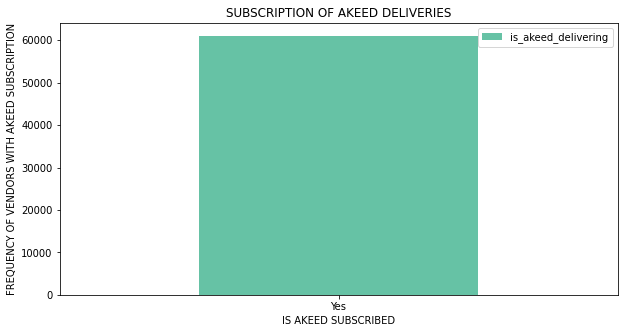

In [30]:
fig, ax = plt.subplots()
final['is_akeed_delivering'].value_counts().plot(ax=ax, kind='bar',figsize=(10,5), cmap='Set2')
plt.xlabel('IS AKEED SUBSCRIBED'); plt.ylabel('FREQUENCY OF VENDORS WITH AKEED SUBSCRIPTION'); plt.title("SUBSCRIPTION OF AKEED DELIVERIES")
plt.xticks(rotation=0); ax.legend()

**PLOT SUMMARY**

1. As all the vendors are subscribed, this feature will not affect the recommendation.


#**2. Bivariate Analysis**

## *Vendor vs Distance between Cust-Vendor*

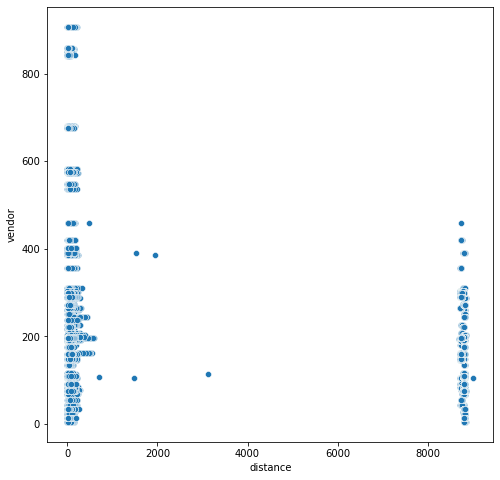

In [31]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=location_cust, x="distance", y='vendor', cmap= 'Set2')

**PLOT SUMMARY**

1. This distance is between the customers (Home or Other) and the vendor location.

2. This graph shows different clusters and also cluters than are at 2000 km, Here there are 2 different regions, first is people living in South America and second one in left are people living in Africa.

3. Here we can conclude that vendor with id's less than 200 are more favorite for people in South America and for people in Africa, there is no such bond.

4. Distance is a very useful feature to recommend the vendor.

##*Vendor Rating vs Customer*

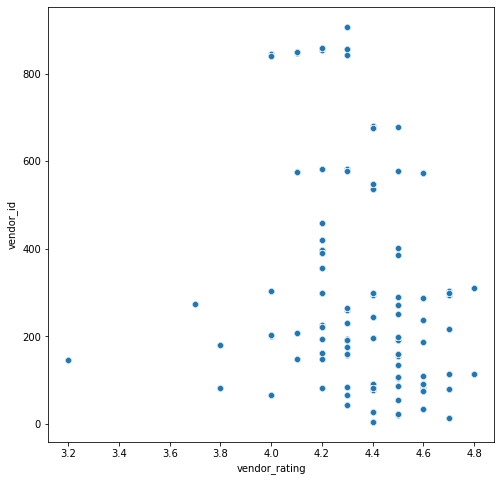

In [32]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=final, x="vendor_rating", y='vendor_id', cmap='Set2')

**PLOT SUMMARY**

1. The range starts from 3.7 to 5 and as close to 5, vendors are more chosen, so this also can be a good feature for recommendation after distance.

#**3. Feature Engineering**

##*Checking Imputations*

In [33]:
pip install dask['complete']

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 12.6 MB/s 
     |████████████████████████████████| 837 kB 31.5 MB/s 
     |████████████████████████████████| 830 kB 30.8 MB/s 
     |████████████████████████████████| 822 kB 35.0 MB/s 
     |████████████████████████████████| 802 kB 10.4 MB/s 
     |████████████████████████████████| 802 kB 41.0 MB/s 
     |████████████████████████████████| 793 kB 35.1 MB/s 
     |████████████████████████████████| 793 kB 33.4 MB/s 
     |████████████████████████████████| 791 kB 13.0 MB/s 
     |████████████████████████████████| 786 kB 33.5 MB/s 
     |████████████████████████████████| 779 kB 43.2 MB/s 
     |████████████████████████████████| 778 kB 10.9 MB/s 
     |████████████████████████████████| 776 kB 37.5 MB/s 
     |████████████████████████████████| 769 kB 38.4 MB/s 
     |████████████████████████████████| 766 kB 36.0 MB/s 
     |█████████████████████████

In [34]:
import pandas as pd
import dask.dataframe as dd
from google.colab import drive
drive.mount('/content/drive')

data = dd.read_csv('/content/drive/MyDrive/Traveloka/train_full.csv')

#removing columns that are not related
train_df = data[['customer_id','gender','location_number','latitude_x',\
           'longitude_x','id','latitude_y','longitude_y','vendor_category_en','delivery_charge',\
           'serving_distance','is_open','prepration_time','vendor_rating','CID X LOC_NUM X VENDOR','target']]
train_df.head(2)
train_df = train_df.head(10000)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# The target is a binary number that represent  
# 1- (CID X LOC_NUM X VENDOR) customer with location number has ordered
# 0- (CID X LOC_NUM X VENDOR) customer with location number has not ordered
len(train_df.target)

10000

In [36]:
# First we will remove those columns which contains more than 25% of null values:
train_df = train_df[train_df.columns[train_df.isnull().mean() < (1-0.25)]]
len(train_df.target)

10000

In [37]:
# We will remove all rows by checking null values column wise, that is to be greater than 70 to stay, otherwise will be removed.
train_df=train_df.loc[train_df.isnull().mean(axis=1) < (1-0.3)]
len(train_df.target)

10000

In [38]:
# If there are missing values, impute it with medians
train_df = train_df.fillna(train_df.median())

##*Visualization of outliers and removal*

* Latitude must be inside -90 < y < 90
* Longitude must be inside -180 < x < 180 

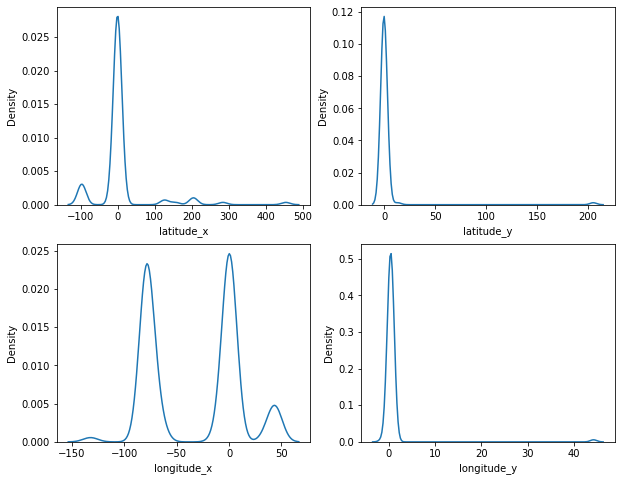

In [39]:
fig, ax = plt.subplots(2,2, figsize=(10,8))
sns.kdeplot(data=train_df, x="latitude_x", palette='Set2', ax = ax[0,0])
sns.kdeplot(data=train_df, x="latitude_y", palette='Set2', ax = ax[0,1])
sns.kdeplot(data=train_df, x="longitude_x", palette='Set2', ax = ax[1,0])
sns.kdeplot(data=train_df, x="longitude_y", palette='Set2', ax = ax[1,1])

In [40]:
# Remove the customers & vendors with invalid latitude and longitude
checked = train_df[(train_df['latitude_x'] < 90) & (train_df['latitude_x'] > -90)]
checked1 = checked[(checked['latitude_y'] < 90) & (checked['latitude_y'] > -90)]
checked2 = checked1[(checked1['longitude_x'] < 180) & (checked1['longitude_x'] > -180)]
train_df = checked2[(checked2['longitude_y'] < 180) & (checked2['longitude_y'] > -180)]
train_df.head(2)

,customer_id,gender,location_number,latitude_x,longitude_x,id,latitude_y,longitude_y,vendor_category_en,delivery_charge,serving_distance,is_open,prepration_time,vendor_rating,CID X LOC_NUM X VENDOR,target
200,TCHWPBT,Male,2,-0.1287,-78.56,4,-0.5884,0.7544,Restaurants,0.0,6.0,1.0,15,4.4,TCHWPBT X 2 X 4,0
201,TCHWPBT,Male,2,-0.1287,-78.56,13,-0.4717,0.7446,Restaurants,0.7,5.0,1.0,14,4.7,TCHWPBT X 2 X 13,0


##*Binning*
There are some fields in which we can perform binning to get best results without affecting the performance metrics.

These are:
1. delivery_charge
2. is_open
3. gender
4. vendor_category_en
5. serving_distance
6. prepration_time
7. vendor_rating

In [41]:
print(train_df['delivery_charge'].value_counts(), "\n")
print(train_df['is_open'].value_counts(), "\n")
print(train_df['gender'].value_counts(), "\n")
print(train_df['vendor_category_en'].value_counts(), "\n")

0.7    4814
0.0    3403
Name: delivery_charge, dtype: int64 

1.0    6972
0.0    1245
Name: is_open, dtype: int64 

Male      7227
Female     990
Name: gender, dtype: int64 

Restaurants       7304
Sweets & Bakes     913
Name: vendor_category_en, dtype: int64 



In [42]:
import numpy as np
train_df['delivery_charge'] = np.where(train_df['delivery_charge'] == 0.7, 1, 0)
train_df['is_open'] = np.where(train_df['is_open'] == 1.0, 1, 0)
train_df['gender'] = np.where(train_df['gender'] == "Female", 1, 0)
train_df['vendor_category_en'] = np.where(train_df['vendor_category_en'] == "Restaurants", 1, 0)

In [43]:
print(train_df['vendor_category_en'].value_counts(), "\n")

1    7304
0     913
Name: vendor_category_en, dtype: int64 



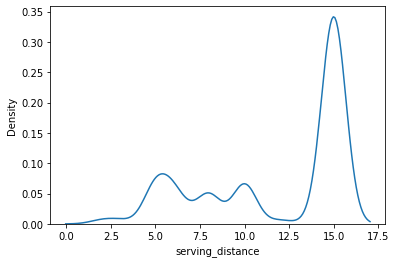

In [44]:
sns.kdeplot(data=train_df, x="serving_distance", palette='Set2')

In [45]:
print(train_df['serving_distance'].value_counts(), "\n")

15.0    4731
10.0     913
5.0      830
6.0      664
8.0      664
2.0       83
14.0      83
7.0       83
3.0       83
12.0      83
Name: serving_distance, dtype: int64 



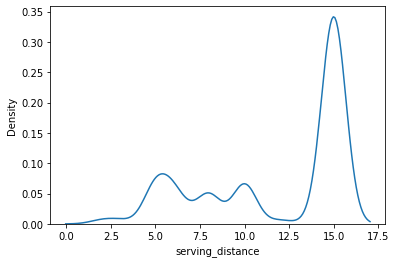

In [46]:
sns.kdeplot(data=train_df, x="serving_distance", palette='Set2')

In [47]:
train_df.loc[(train_df['serving_distance'] <= 6, 'serving_distance')] = 1
train_df.loc[((train_df['serving_distance'] > 6) & (train_df['serving_distance'] <= 10), 'serving_distance')] = 2
train_df.loc[((train_df['serving_distance'] > 10) & (train_df['serving_distance'] <= 12), 'serving_distance')] = 3
train_df.loc[(train_df['serving_distance'] > 12, 'serving_distance')] = 4

In [48]:
print(train_df['prepration_time'].value_counts(), "\n")

15    2905
10    2075
14     581
17     498
11     415
13     415
16     332
20     249
19     166
12     166
18     166
21      83
45      83
5       83
Name: prepration_time, dtype: int64 



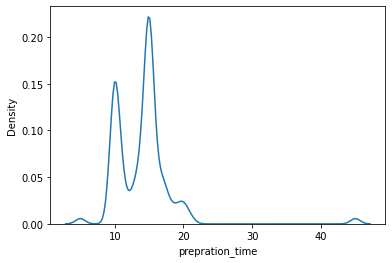

In [49]:
sns.kdeplot(data=train_df, x="prepration_time", palette='Set2')

In [50]:
# We can see there are major 4 categories of bin ranges, 0-10, 10-15, 15-20 and above 20
train_df.loc[(train_df['prepration_time'] <= 10, 'preparation_time_en')] = 1
train_df.loc[((train_df['prepration_time'] > 10) & (train_df['prepration_time'] <= 15), 'preparation_time_en')] = 2
train_df.loc[((train_df['prepration_time'] > 15) & (train_df['prepration_time'] <= 20), 'preparation_time_en')] = 3
train_df.loc[(train_df['prepration_time'] > 20, 'preparation_time_en')] = 4

In [51]:
print(train_df['vendor_rating'].value_counts(), "\n")

4.5    1577
4.3    1411
4.2    1245
4.4    1162
4.6     830
4.7     581
4.0     498
4.1     415
3.8     166
4.8     166
3.2      83
3.7      83
Name: vendor_rating, dtype: int64 



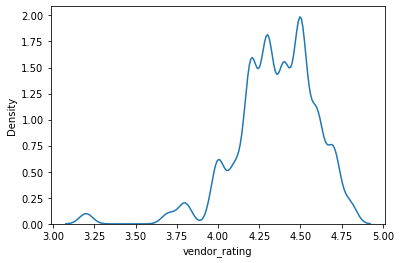

In [52]:
sns.kdeplot(data=train_df, x="vendor_rating", palette='Set2')

In [53]:
# (3.7 and below) as 1, (3.7-4.0) as 2, (4.0-4.2) as 3, (4.2-4.5) as 4, (4.5 and above) as 5
train_df.loc[(train_df['vendor_rating'] <= 3.7, 'vendor_rating_en')] = 1
train_df.loc[((train_df['vendor_rating'] > 3.7) & (train_df['vendor_rating'] <= 4.0), 'vendor_rating_en')] = 2
train_df.loc[((train_df['vendor_rating'] > 4.0) & (train_df['vendor_rating'] <= 4.2), 'vendor_rating_en')] = 3
train_df.loc[((train_df['vendor_rating'] > 4.2) & (train_df['vendor_rating'] <= 4.5), 'vendor_rating_en')] = 4
train_df.loc[(train_df['vendor_rating'] > 4.5, 'vendor_rating_en')] = 5

In [54]:
train_df.drop(['location_type'], axis=1, inplace=True, errors='ignore')
train_df.head(2)

,customer_id,gender,location_number,latitude_x,longitude_x,id,latitude_y,longitude_y,vendor_category_en,delivery_charge,serving_distance,is_open,prepration_time,vendor_rating,CID X LOC_NUM X VENDOR,target,preparation_time_en,vendor_rating_en
200,TCHWPBT,0,2,-0.1287,-78.56,4,-0.5884,0.7544,1,0,1.0,1,15,4.4,TCHWPBT X 2 X 4,0,2.0,4.0
201,TCHWPBT,0,2,-0.1287,-78.56,13,-0.4717,0.7446,1,1,1.0,1,14,4.7,TCHWPBT X 2 X 13,0,2.0,5.0


##*Normalization*
As all the data has been binned, the need for normalization or scaling of data has beem reduced, Further we will see the feature importance to find out whether our preprocessed columns have been made a difference or not.

##*Feature Selection (PROVING THE EDA)*

In [55]:
corr = train_df[['location_number','gender','vendor_category_en','delivery_charge',\
           'serving_distance','is_open','prepration_time','vendor_rating','target']]
corr.corr()

,location_number,gender,vendor_category_en,delivery_charge,serving_distance,is_open,prepration_time,vendor_rating,target
location_number,1.000000e+00,3.522071e-01,-7.948649e-16,-3.372469e-16,-8.271069e-17,1.037020e-15,3.700652e-16,-2.653741e-15,-2.918413e-02
gender,3.522071e-01,1.000000e+00,1.031586e-16,-5.028148e-16,1.693816e-15,4.222684e-16,-1.520994e-15,-1.622197e-14,-2.402698e-02
vendor_category_en,-7.948649e-16,1.031586e-16,1.000000e+00,1.595041e-01,-1.074355e-01,1.195229e-01,-2.366616e-01,-3.158052e-02,5.050505e-03
delivery_charge,-3.372469e-16,-5.028148e-16,1.595041e-01,1.000000e+00,1.164292e-01,-1.837113e-01,9.896678e-02,4.704182e-02,1.933383e-02
serving_distance,-8.271069e-17,1.693816e-15,-1.074355e-01,1.164292e-01,1.000000e+00,-1.628780e-01,1.038371e-01,-1.767540e-01,-2.136145e-02
is_open,1.037020e-15,4.222684e-16,1.195229e-01,-1.837113e-01,-1.628780e-01,1.000000e+00,-2.395448e-01,3.009381e-01,-4.471902e-17
prepration_time,3.700652e-16,-1.520994e-15,-2.366616e-01,9.896678e-02,1.038371e-01,-2.395448e-01,1.000000e+00,-1.251319e-01,3.971942e-02
vendor_rating,-2.653741e-15,-1.622197e-14,-3.158052e-02,4.704182e-02,-1.767540e-01,3.009381e-01,-1.251319e-01,1.000000e+00,4.944425e-02
target,-2.918413e-02,-2.402698e-02,5.050505e-03,1.933383e-02,-2.136145e-02,-4.471902e-17,3.971942e-02,4.944425e-02,1.000000e+00


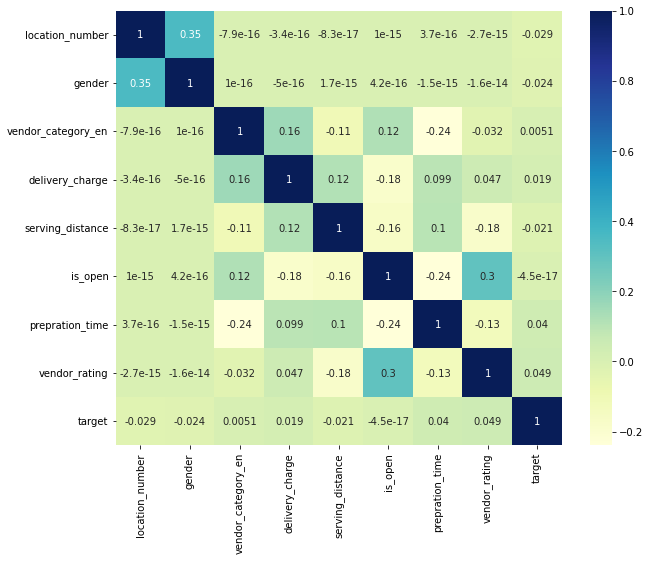

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(corr.corr(), cmap="YlGnBu", annot=True)

In [57]:
feature_x = train_df[['location_number','gender','latitude_x','longitude_x','id','latitude_y','longitude_y','vendor_category_en','delivery_charge',\
           'serving_distance','is_open','prepration_time','vendor_rating']]
feature_y = train_df['target']

In [58]:
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(feature_x,feature_y)
# display the relative importance of each attribute
print(model.feature_importances_)

[0.1544911  0.01724142 0.39843903 0.23961932 0.0353294  0.03303558
 0.03390458 0.00466288 0.00796915 0.00862003 0.00423747 0.03214118
 0.03030886]


In [59]:
# plotting feature importances using plt
feature_imp = model.feature_importances_
labels = model.feature_names_in_
importances = pd.DataFrame(zip(labels, feature_imp), columns=('label', 'importance')).sort_values(by='importance', ascending=False)
print(importances)

                 label  importance
2           latitude_x    0.398439
3          longitude_x    0.239619
0      location_number    0.154491
4                   id    0.035329
6          longitude_y    0.033905
5           latitude_y    0.033036
11     prepration_time    0.032141
12       vendor_rating    0.030309
1               gender    0.017241
9     serving_distance    0.008620
8      delivery_charge    0.007969
7   vendor_category_en    0.004663
10             is_open    0.004237


**PLOT SUMMARY**

1. It shows that Gender, Location (latitude and longitude), Location Number is very important features as already seen in EDA. -- Proven

# **4. Encoding Train And Test**

In [60]:
import pandas as pd
#data = pd.read_csv('/content/drive/MyDrive/Traveloka/train_full.csv')
#data = data.head(10000)
#data.to_csv('/content/drive/MyDrive/Traveloka/train_data.csv')
train = pd.read_csv('/content/drive/MyDrive/Traveloka/train_data.csv')

In [61]:
# taking only important columns
train = train[['gender', 'location_number', 'location_type', 'latitude_x',\
           'longitude_x', 'latitude_y', 'longitude_y', 'id', 'vendor_category_en', 'delivery_charge',\
           'serving_distance', 'is_open', 'prepration_time', 'vendor_rating', 'target']] 
print(train.shape)
train.head(2)

(10000, 15)


,gender,location_number,location_type,latitude_x,longitude_x,latitude_y,longitude_y,id,vendor_category_en,delivery_charge,serving_distance,is_open,prepration_time,vendor_rating,target
0,Male,0,Work,-96.44,-67.2,-0.5884,0.7544,4,Restaurants,0.0,6.0,1.0,15,4.4,0
1,Male,0,Work,-96.44,-67.2,-0.4717,0.7446,13,Restaurants,0.7,5.0,1.0,14,4.7,0


In [62]:
!pip install haversine
import haversine
from haversine import haversine_vector, Unit

dist = []
train.dropna(inplace=True)
for i in train.values:
    a = (i[4], i[5])
    b = (i[6], i[7])
    dist.append(haversine_vector([a], [b], Unit.KILOMETERS)[0])

train['distance'] = dist
train.head(2)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,gender,location_number,location_type,latitude_x,longitude_x,latitude_y,longitude_y,id,vendor_category_en,delivery_charge,serving_distance,is_open,prepration_time,vendor_rating,target,distance
0,Male,0,Work,-96.44,-67.2,-0.5884,0.7544,4,Restaurants,0.0,6.0,1.0,15,4.4,0,7564.728539
1,Male,0,Work,-96.44,-67.2,-0.4717,0.7446,13,Restaurants,0.7,5.0,1.0,14,4.7,0,7628.224806


In [63]:
# label encoding the string data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['gender']= le.fit_transform(train['gender'].astype(str))
train['location_type']= le.fit_transform(train['location_type'].astype(str))
train['vendor_category_en']= le.fit_transform(train['vendor_category_en'].astype(str))
train.head(2)

,gender,location_number,location_type,latitude_x,longitude_x,latitude_y,longitude_y,id,vendor_category_en,delivery_charge,serving_distance,is_open,prepration_time,vendor_rating,target,distance
0,1,0,2,-96.44,-67.2,-0.5884,0.7544,4,0,0.0,6.0,1.0,15,4.4,0,7564.728539
1,1,0,2,-96.44,-67.2,-0.4717,0.7446,13,0,0.7,5.0,1.0,14,4.7,0,7628.224806


In [64]:
print(train.shape)
train.columns

(6100, 16)


Index(['gender', 'location_number', 'location_type', 'latitude_x',
       'longitude_x', 'latitude_y', 'longitude_y', 'id', 'vendor_category_en',
       'delivery_charge', 'serving_distance', 'is_open', 'prepration_time',
       'vendor_rating', 'target', 'distance'],
      dtype='object')

In [65]:
# applying one-hot encoding to all the categorical data
gen = pd.get_dummies(train['gender'])
ltype = pd.get_dummies(train['location_type'])
venc = pd.get_dummies(train['vendor_category_en'])
dev = pd.get_dummies(train['delivery_charge'])
dis = pd.get_dummies(train['serving_distance'])
opn = pd.get_dummies(train['is_open'])
ptime = pd.get_dummies(train['prepration_time'])
rat = pd.get_dummies(train['vendor_rating'])

In [66]:
final_train = pd.concat([train[['latitude_x','longitude_x','latitude_y','longitude_y','id','location_number','distance']], \
                         gen, ltype, venc, dev, dis, opn, ptime, rat, train['target']], axis=1)
final_train.shape

(6100, 55)

In [67]:
#encoding the test files
test = pd.read_csv('/content/drive/MyDrive/Traveloka/test_full.csv')
test.head(2)

,customer_id,gender,status_x,verified_x,created_at_x,updated_at_x,location_number,location_type,latitude_x,longitude_x,...,one_click_vendor,country_id,city_id,created_at_y,updated_at_y,device_type,display_orders,location_number_obj,id_obj,CID X LOC_NUM X VENDOR
0,ICE2DJP,Male,1.0,1.0,2018-02-07 16:45:36,2018-02-07 16:45:36,0.0,NaN,-96.44,-67.2,...,Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3.0,1.0,0.0,4.0,ICE2DJP X 0 X 4
1,ICE2DJP,Male,1.0,1.0,2018-02-07 16:45:36,2018-02-07 16:45:36,0.0,NaN,-96.44,-67.2,...,Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3.0,1.0,0.0,13.0,ICE2DJP X 0 X 13


In [68]:
test = test[['gender','location_number','location_type','latitude_x',\
           'longitude_x','latitude_y','longitude_y','id','vendor_category_en','delivery_charge',\
           'serving_distance','is_open','prepration_time','vendor_rating']]
print(test.shape)
test.head(2)

(1672000, 14)


,gender,location_number,location_type,latitude_x,longitude_x,latitude_y,longitude_y,id,vendor_category_en,delivery_charge,serving_distance,is_open,prepration_time,vendor_rating
0,Male,0.0,NaN,-96.44,-67.2,-0.5884,0.7544,4.0,Restaurants,0.0,6.0,1.0,15.0,4.4
1,Male,0.0,NaN,-96.44,-67.2,-0.4717,0.7446,13.0,Restaurants,0.7,5.0,1.0,14.0,4.7


In [69]:
import haversine
from haversine import haversine_vector, Unit

dist = []
test.dropna(inplace=True)
for i in test.values:
    a = (i[4], i[5])
    b = (i[6], i[7])
    dist.append(haversine_vector([a], [b], Unit.KILOMETERS)[0])

test['distance'] = dist
test.head(2)

,gender,location_number,location_type,latitude_x,longitude_x,latitude_y,longitude_y,id,vendor_category_en,delivery_charge,serving_distance,is_open,prepration_time,vendor_rating,distance
200,Male,2.0,Other,-95.1,43.7,-0.5884,0.7544,4.0,Restaurants,0.0,6.0,1.0,15.0,4.4,4796.965287
201,Male,2.0,Other,-95.1,43.7,-0.4717,0.7446,13.0,Restaurants,0.7,5.0,1.0,14.0,4.7,4959.594290


In [70]:
test.shape

(628000, 15)

In [71]:
# label encoding the string data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
test['gender']= le.fit_transform(test['gender'].astype(str))
test['location_type']= le.fit_transform(test['location_type'].astype(str))
test['vendor_category_en']= le.fit_transform(test['vendor_category_en'].astype(str))


In [72]:
gen = pd.get_dummies(test['gender'])
ltype = pd.get_dummies(test['location_type'])
venc = pd.get_dummies(test['vendor_category_en'])
dev = pd.get_dummies(test['delivery_charge'])
dis = pd.get_dummies(test['serving_distance'])
opn = pd.get_dummies(test['is_open'])
ptime = pd.get_dummies(test['prepration_time'])
rat = pd.get_dummies(test['vendor_rating'])

In [73]:
final_test = pd.concat([test[['latitude_x','longitude_x','latitude_y','longitude_y','id','location_number','distance']],gen,ltype,venc,dev,dis,opn,ptime,rat],axis=1)
print(test.shape)
final_test.head(2)

(628000, 15)


,latitude_x,longitude_x,latitude_y,longitude_y,id,location_number,distance,0,1,0,...,3.8,4.0,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8
200,-95.1,43.7,-0.5884,0.7544,4.0,2.0,4796.965287,0,1,0,...,0,0,0,0,0,1,0,0,0,0
201,-95.1,43.7,-0.4717,0.7446,13.0,2.0,4959.594290,0,1,0,...,0,0,0,0,0,0,0,0,1,0


#**5. Build Model**

In [74]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process
import multiprocessing
import codecs# this is used for file operations 
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [75]:
data = train.copy()
data.head(2)

,gender,location_number,location_type,latitude_x,longitude_x,latitude_y,longitude_y,id,vendor_category_en,delivery_charge,serving_distance,is_open,prepration_time,vendor_rating,target,distance
0,1,0,2,-96.44,-67.2,-0.5884,0.7544,4,0,0.0,6.0,1.0,15,4.4,0,7564.728539
1,1,0,2,-96.44,-67.2,-0.4717,0.7446,13,0,0.7,5.0,1.0,14,4.7,0,7628.224806


In [76]:
#creating data for training and target
y = data['target']
X = data.drop(['target'], axis=1)
X = X.fillna(0)
print(X.shape, y.shape)

(6100, 15) (6100,)


##*Logistic Regression*

In [77]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.33)

alpha = [10 ** x for x in range(-3, 3)]
log_error=[]

# below code hypertune the parameters and do calibrations

for i in alpha: #hyperparameter ALpha tuning
    lor = LogisticRegression(penalty='l2', C=i, class_weight='balanced')
    
    lor.fit(X_train,y_train)
    clf = CalibratedClassifierCV(lor, method="sigmoid") #caliberation used
    
    clf.fit(X_train, y_train)
    predict= clf.predict_proba(X_cv)
    log_error.append(log_loss(y_cv, predict, labels=lor.classes_, eps=1e-15)) #printing log error for tuning
    
for i in range(len(log_error)):
    print ('Log_loss for C = ',alpha[i],'is',log_error[i])

best_alpha = np.argmin(log_error) #choosing best alpha

#Applying hyper-tuned parameter for test data
logistic = LogisticRegression(penalty='l2', C=alpha[best_alpha], class_weight='balanced')

#getting final model ready
logistic.fit(X_train,y_train)
clf = CalibratedClassifierCV(logistic, method="sigmoid")
clf.fit(X_train, y_train)

#predicting for F1 score,Precision and Recall
pred = clf.predict(X_test) 

Log_loss for C =  0.001 is 0.09485338306565186
Log_loss for C =  0.01 is 0.09453495077266662
Log_loss for C =  0.1 is 0.09447651987936917
Log_loss for C =  1 is 0.09467673907211427
Log_loss for C =  10 is 0.09447406819958858
Log_loss for C =  100 is 0.09443961036634935


In [78]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

y_predict = []

for i in pred:
  if i <= 0.5:
    y_predict.append(0)
  else:
    y_predict.append(1)

#printing metrics
print('Accuracy Score: ',accuracy_score(y_test, y_predict))
print('Precision: ',precision_score(y_test, y_predict))
print('Recall: ',recall_score(y_test, y_predict))

f1 = (2*(precision_score(y_test, y_predict))*(recall_score(y_test, y_predict)))/((recall_score(y_test, y_predict))+(precision_score(y_test, y_predict)))
print('The F1 score:', f1)


Accuracy Score:  0.9865871833084948
Precision:  0.0
Recall:  0.0
The F1 score: nan


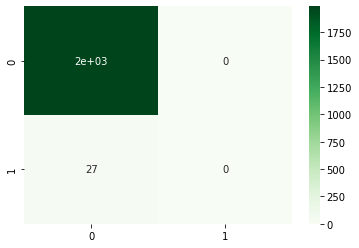

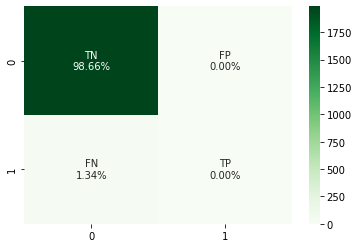

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline
arr = confusion_matrix(y_test, y_predict)

sns.heatmap(arr, annot=True, cmap='Greens'); plt.show()

gnames = ['TN','FP','FN','TP']
gper = ["{0:.2%}".format(x) for x in (arr.flatten()/np.sum(arr))]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(gnames, gper)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(arr, annot=labels, fmt='', cmap='Greens'); plt.show()

##*Random Forest*

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.33)

In [81]:
alpha=[10, 50, 100, 300]
cvlog_error=[]
trlog_error=[]

# below code hyperparameter tuning and calibration

for i in alpha:

    clf1 = RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    clf1.fit(X_train,y_train)

    pred = clf1.predict_proba(X_cv)
    cvlog_error.append(log_loss(y_cv, pred, labels=clf.classes_, eps=1e-15))

In [82]:
from matplotlib import pyplot as plt

for i in range(len(cvlog_error)):
    print ('Log_loss for n_estimator = ',alpha[i],'is',cvlog_error[i])

best_alpha = np.argmin(cvlog_error)

Log_loss for n_estimator =  10 is 0.6042807960994481
Log_loss for n_estimator =  50 is 0.4898447025169588
Log_loss for n_estimator =  100 is 0.445998814825241
Log_loss for n_estimator =  300 is 0.3601587673900747


In [83]:
cal_clf = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)
cal_clf.fit(X_train,y_train)

pred = cal_clf.predict_proba(X_train)
print('For values of best alpha = ', 10, "The train log loss is:", log_loss(y_train, pred))

pred = cal_clf.predict_proba(X_cv)
print('For values of best alpha = ', 10, "The cross validation log loss is:", log_loss(y_cv, pred))

pred = cal_clf.predict_proba(X_test)
print('For values of best alpha = ', 10, "The test log loss is:", log_loss(y_test, pred))

For values of best alpha =  10 The train log loss is: 0.011109170993397574
For values of best alpha =  10 The cross validation log loss is: 0.6042807960994481
For values of best alpha =  10 The test log loss is: 0.4989781438663136


In [84]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

predict=cal_clf.predict(X_test)

# printing metrics
print('Accuracy Score: ',accuracy_score(y_test, predict))
print('Precision: ',precision_score(y_test, predict))
prec=precision_score(y_test, predict)
print('Recall: ',recall_score(y_test, predict))
rec=recall_score(y_test, predict)

f1 = (2*prec*rec)/(rec+prec+0.00001)
print('The F1 score:', f1)

Accuracy Score:  0.9811227024341779
Precision:  0.0
Recall:  0.0
The F1 score: 0.0


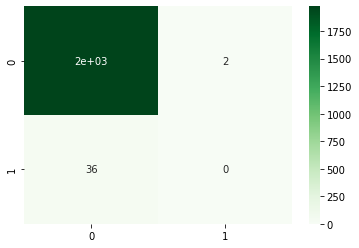

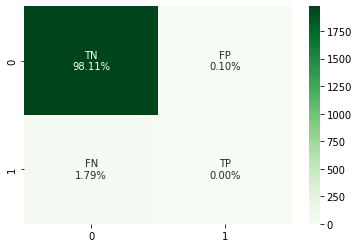

In [85]:
arr = confusion_matrix(y_test, predict)
sns.heatmap(arr, annot=True, cmap='Greens'); plt.show()

gnames = ['TN','FP','FN','TP']
gper = ["{0:.2%}".format(x) for x in (arr.flatten()/np.sum(arr))]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(gnames,gper)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(arr, annot=labels, fmt='', cmap='Greens')

##*XGBoost*

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.33)
alpha = [10, 50, 100, 200]

cvlog_error=[]
# below code hypertune the parameters and do calibration

for i in alpha:
    print('Alpha:', i)
    xg_clf = XGBClassifier(n_estimators=i,nthread=-1)
    xg_clf.fit(X_train, y_train)

    pred = xg_clf.predict_proba(X_cv)
    cvlog_error.append(log_loss(y_cv, pred, labels=clf.classes_, eps=1e-15))

for i in range(len(cvlog_error)):
    print ('log_loss for c = ',alpha[i],'is',cvlog_error[i])

best_alpha = np.argmin(cvlog_error)

Alpha: 10
Alpha: 50
Alpha: 100
Alpha: 200
log_loss for c =  10 is 0.235891276140669
log_loss for c =  50 is 0.08261152301908777
log_loss for c =  100 is 0.08148461558734477
log_loss for c =  200 is 0.08479573107987669


In [87]:
xg_clf = XGBClassifier(n_estimators=200, nthread=-1)
xg_clf.fit(X_train, y_train)

predict_y = xg_clf.predict_proba(X_train)
print('For values of best alpha = ', 200, "The train log loss is:", log_loss(y_train, predict_y))

predict_y = xg_clf.predict_proba(X_cv)
print('For values of best alpha = ',  200, "The cross validation log loss is:", log_loss(y_cv, predict_y))

predict_y = xg_clf.predict_proba(X_test)
print('For values of best alpha = ',  200, "The test log loss is:", log_loss(y_test, predict_y))

For values of best alpha =  200 The train log loss is: 0.03838671911261733
For values of best alpha =  200 The cross validation log loss is: 0.08479573107987669
For values of best alpha =  200 The test log loss is: 0.06938006177624566


In [88]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

predict = xg_clf.predict(X_test)

print('Accuracy: ',accuracy_score(y_test, predict))
print('Precision: ',precision_score(y_test, predict))
prec=precision_score(y_test, predict)
print('Recall: ',recall_score(y_test, predict))
rec=recall_score(y_test, predict)

f1=(2*prec*rec)/(rec+prec+0.00000001)
print('The F1 score:', f1)

Accuracy:  0.9855936413313463
Precision:  0.0
Recall:  0.0
The F1 score: 0.0


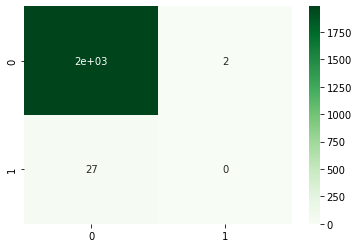

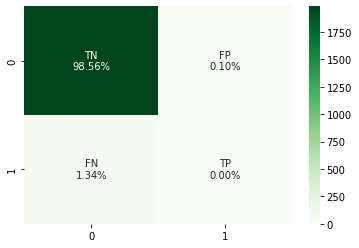

In [89]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

arr = confusion_matrix(y_test, predict)
sns.heatmap(arr, annot=True, cmap='Greens'); plt.show()

gnames = ['TN','FP','FN','TP']
gper = ["{0:.2%}".format(x) for x in (arr.flatten()/np.sum(arr))]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(gnames,gper)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(arr, annot=labels, fmt='', cmap='Greens')

##*XGBoost with Random Search*

In [90]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.33)
xg = XGBClassifier(n_estimators=200, learning_rate=0.05, colsample_bytree=1, max_depth=3)
xg.fit(X_train, y_train)

# below code hypertune the parameters and calibration
predict_y = xg.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))

predict_y = xg.predict_proba(X_cv)
print ('cv loss',log_loss(y_cv, predict_y))

predict_y = xg.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))

train loss 0.05640775527091164
cv loss 0.09135107730020903
test loss 0.05855148050111882


In [91]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

predict = xg.predict(X_test)

print('Accuracy Score: ',accuracy_score(y_test, predict))
print('Precision: ',precision_score(y_test, predict))
prec = precision_score(y_test, predict)
print('Recall: ',recall_score(y_test, predict))
rec = recall_score(y_test, predict)

f1 = (2*prec*rec)/(rec+prec+0.00001)
print('The F1 score:',f1)

Accuracy Score:  0.9885742672627919
Precision:  0.0
Recall:  0.0
The F1 score: 0.0


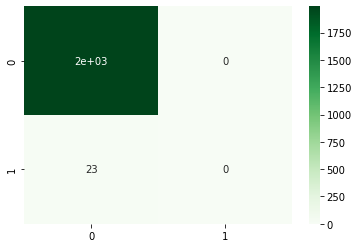

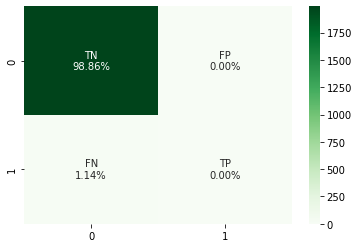

In [92]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

arr = confusion_matrix(y_test, predict)
sns.heatmap(arr, annot=True, cmap='Greens'); plt.show()

gnames = ['TN','FP','FN','TP']
gper = ["{0:.2%}".format(x) for x in (arr.flatten()/np.sum(arr))]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(gnames,gper)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(arr, annot=labels, fmt='', cmap='Greens'); plt.show()

##*Using SMOTE*

In [93]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

# printing the counter fucntion to get frequency of classes
counter = Counter(y)
print(counter)

Counter({0: 6003, 1: 97})


In [95]:
# oversampling the lower data 
over = SMOTE(sampling_strategy=0.4)
X, y = over.fit_resample(X, y)

In [96]:
counter = Counter(y)
print(counter)

Counter({0: 6003, 1: 2401})


In [97]:
# undersampling the upper data
under = RandomUnderSampler(sampling_strategy=0.6)
X, y = under.fit_resample(X,y)
counter = Counter(y)
print(counter)

Counter({0: 4001, 1: 2401})


In [98]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size = 0.33)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train, test_size = 0.33)

In [99]:
xg = XGBClassifier(n_estimators=250, learning_rate=0.05, colsample_bytree=1, max_depth=3)
xg.fit(X_train,y_train)

predict_y = xg.predict_proba(X_train)
print ('train loss', log_loss(y_train, predict_y))

predict_y = xg.predict_proba(X_cv)
print ('cv loss', log_loss(y_cv, predict_y))

predict_y = xg.predict_proba(X_test)
print ('test loss', log_loss(y_test, predict_y))

train loss 0.12112057639715115
cv loss 0.15471007907634665
test loss 0.13458260587544188


In [100]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

predict = xg.predict(X_test)

# printing metrics
print('Accuracy Score: ', accuracy_score(y_test, predict))
print('Precision: ', precision_score(y_test, predict))
prec = precision_score(y_test, predict)
print('Recall: ', recall_score(y_test, predict))
rec=recall_score(y_test, predict)

f1 = (2*prec*rec)/(rec+prec+0.000000000000001)
print('The F1 score:', f1)

Accuracy Score:  0.971131093232371
Precision:  0.966794380587484
Recall:  0.9558080808080808
The F1 score: 0.9612698412698406


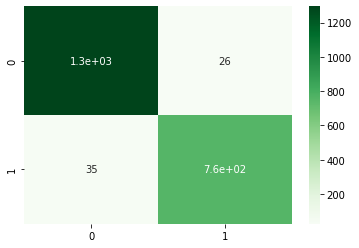

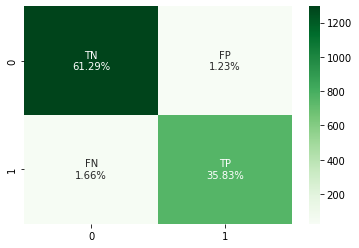

In [101]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

arr = confusion_matrix(y_test, predict)
sns.heatmap(arr, annot=True, cmap='Greens')
plt.show()

gnames = ['TN','FP','FN','TP']
gper = ["{0:.2%}".format(x) for x in (arr.flatten()/np.sum(arr))] 

labels = [f"{v1}\n{v2}" for v1, v2 in zip(gnames, gper)] 
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(arr, annot=labels, fmt='', cmap='Greens')

##*Store the model file*

In [102]:
import pickle
pickle.dump(xg, open('/content/drive/MyDrive/Traveloka/model.pkl', 'wb'))